In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%config InlineBackend.figure_format = 'retina'

## Описание проекта

Имеется список гипотез для увеличения выручки.

Необходимо 
1. приоритизировать гипотезы, 
1. запустить A/B-тест,
1. проанализировать результаты.

### Описание данных

#### Ideas
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Orders
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

#### Visitors

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Приоритизация гипотез.

Применим фреймворки ICE и RICE, отсортируем по RICE, подсветим рейтинги каждой гипотезы

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [2]:
ideas = (
    pd.read_csv('/datasets/hypothesis.csv')
    .assign (ICE = lambda x: (x['Impact'] * x['Confidence'] / x['Efforts']).round(1))
    .assign (RICE = lambda x: (x['ICE'] * x['Reach']))
    .sort_values('RICE', ascending = False)
    .style.background_gradient(cmap='magma', subset = ['ICE', 'RICE'])
)

ideas

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.300000,39.900000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.100000,8.800000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.300000,3.900000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


Приоритизация изменилась, т.к. параметр Reach оказал существенное влияние.

## Проверка результатов А/В теста

загрузим данные, приведем столбцы с датами к корректному формату, просмотрим выборочно строки

In [3]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
for i in [orders, visitors]: 
    print ('-------------------------')
    i['date'] = i['date'].map(
        lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

    display (i.info())
    display (i.sample(5))

-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
1044,1814628689,1404934699,2019-08-11,8640,A
811,3278896715,3451176495,2019-08-21,1540,A
86,4130553949,3736064128,2019-08-22,1290,A
686,1573514293,3148168974,2019-08-29,5150,B
412,2100491088,1147554328,2019-08-06,990,B


-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

,date,group,visitors
30,2019-08-31,A,699
0,2019-08-01,A,719
3,2019-08-04,A,717
22,2019-08-23,A,468
2,2019-08-03,A,507


In [5]:
# переименуем transactionId в orderId, visitorID в 'userId' для удобства использования готового кода
orders.rename(columns={'transactionId':'orderId', 'visitorId':'userId'}, inplace=True)
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### Проверим расчетные параметры для А/В теста

Мы можем проверить только размер выборки, т.к. для проверки длительности теста не хватает данных обо всех посетителях сайта и какую долю от них составляют участники А/В теста

Предположу, что исходная конверсия порядка 3.5% (согласно расчету далее для задания "постройте график кумулятивной конверсии", и соответственно нам важно выявить разницу с точностью до 15% (относительно). Необходимый размер выборки для такой точности - 19646 на человек на вариацию (согласно калькулятору на сайте https://www.evanmiller.org/ab-testing/sample-size.html). Наша выборка примерно соответствует необходимой.

In [6]:
visitors.groupby('group').agg({'visitors':'sum'})

,visitors
group,
A,18736
B,18916


In [7]:
dupl_users = (
    orders
    .pivot_table (
        index = 'userId',
        columns = 'group',
        values = 'orderId',
        aggfunc = 'nunique'
    )
    .query('not A.isna() and not B.isna()')
    .assign (AB = lambda x: x['A'] + x['B']).sort_values(by='AB', ascending=False)
)

display (dupl_users.head(5))

group,A,B,AB
userId,,,
4256040402,7.0,4.0,11.0
2458001652,5.0,6.0,11.0
2378935119,4.0,5.0,9.0
2038680547,5.0,3.0,8.0
1230306981,3.0,2.0,5.0


Интересно, что среди этих пользователей много тех, кто сделал больше 2 покупок и мы их в любом случае отбросим как пользователей с большим коичеством заказов. Посчитаю, сколько пользователей нужно будет отбросить с учетом будущей очистки данных

In [8]:
dupl_users['AB'].value_counts(sort=False)

3.0     10
2.0     35
5.0      6
11.0     2
4.0      3
8.0      1
9.0      1
Name: AB, dtype: int64

In [9]:
to_clean = dupl_users.query('AB < 3')['A'].count()
print (to_clean, 'пользователей попавших в обе группы, нужно отбросить')
print ('{:.2%}'.format(to_clean / orders['userId'].nunique()), '- процент от общего количества пользователей, сделавших покупки')

35 пользователей попавших в обе группы, нужно отбросить
3.39% - процент от общего количества пользователей, сделавших покупки


Удалим их из общего набора:

In [10]:
print (orders['userId'].nunique())

orders = orders.query('userId not in @dupl_users.index')

print (orders['userId'].nunique())

1031
973


### Задания:

#### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

воспользуемся кодом из уроков, чтобы агрегировать и подготовить данные

In [11]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования

''

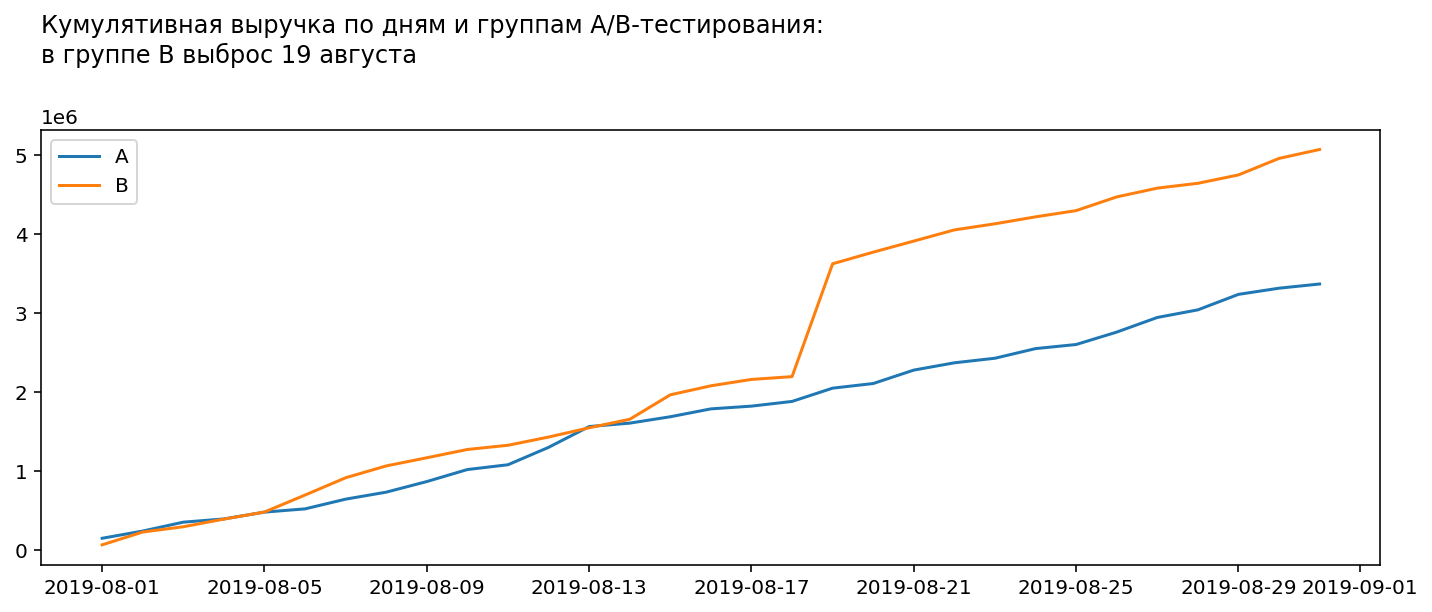

In [12]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


plt.figure(figsize=(12,4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], 
         label='B')

plt.title('Кумулятивная выручка по дням и группам A/B-тестирования: \nв группе В выброс 19 августа \n', loc='left', pad=20)
plt.legend()
; 

- ВЫВОД: кумулятивная выручка в группе В растет быстрее. Однако явный отрыв происходит за счет одного скачка между 18 и 19 августа, который может быть вызван выбросом, искажающим результаты. Необходимо проверить набор данных на выбросы и, если необходимо, скорректировать.

#### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

Разделим кумулятивную выручку на кумулятивное число заказов:

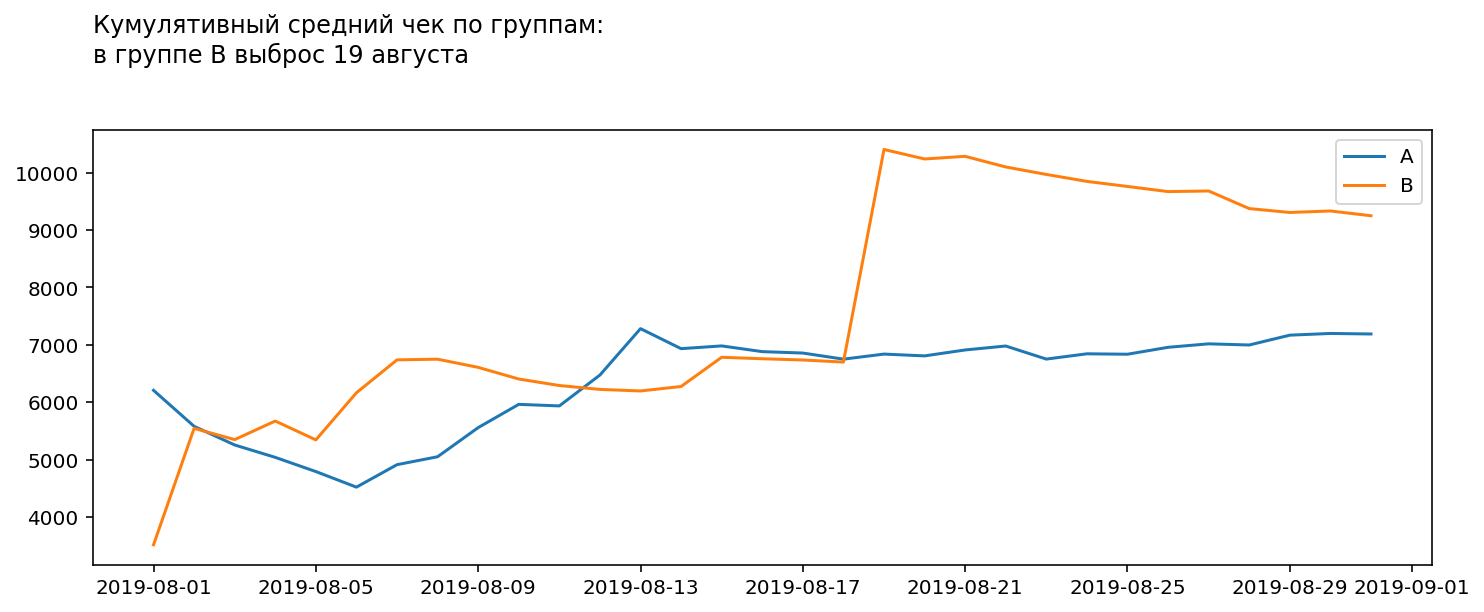

In [13]:
plt.figure(figsize=(12,4))
plt.title('Кумулятивный средний чек по группам: \nв группе В выброс 19 августа \n', loc='left', pad=20)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend(); 

In [14]:
orders.sort_values("revenue", ascending = False).head(10).style.bar(subset='revenue', vmin=0)

,orderId,userId,date,revenue,group
425,590470918,1920142716,2019-08-19 00:00:00,1294500,B
1196,3936777065,2108080724,2019-08-15 00:00:00,202740,B
1136,666610489,1307669133,2019-08-13 00:00:00,92550,A
744,3668308183,888512513,2019-08-27 00:00:00,86620,B
743,3603576309,4133034833,2019-08-09 00:00:00,67990,A
1103,1348774318,1164614297,2019-08-12 00:00:00,66350,A
1099,316924019,148427295,2019-08-12 00:00:00,65710,A
949,1347999392,887908475,2019-08-21 00:00:00,60450,A
940,2420050534,4003628586,2019-08-08 00:00:00,58550,B
131,3163614039,2254586615,2019-08-22 00:00:00,53904,A


И действительно, 19 августа был заказ на 1300 тыс, что почти в 6,4 раза больше второго по стоимости заказа за время наблюдений

- ВЫВОД: видим резкий скачок среднего чека. Выброс связан с единственным очень крупным заказом

#### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

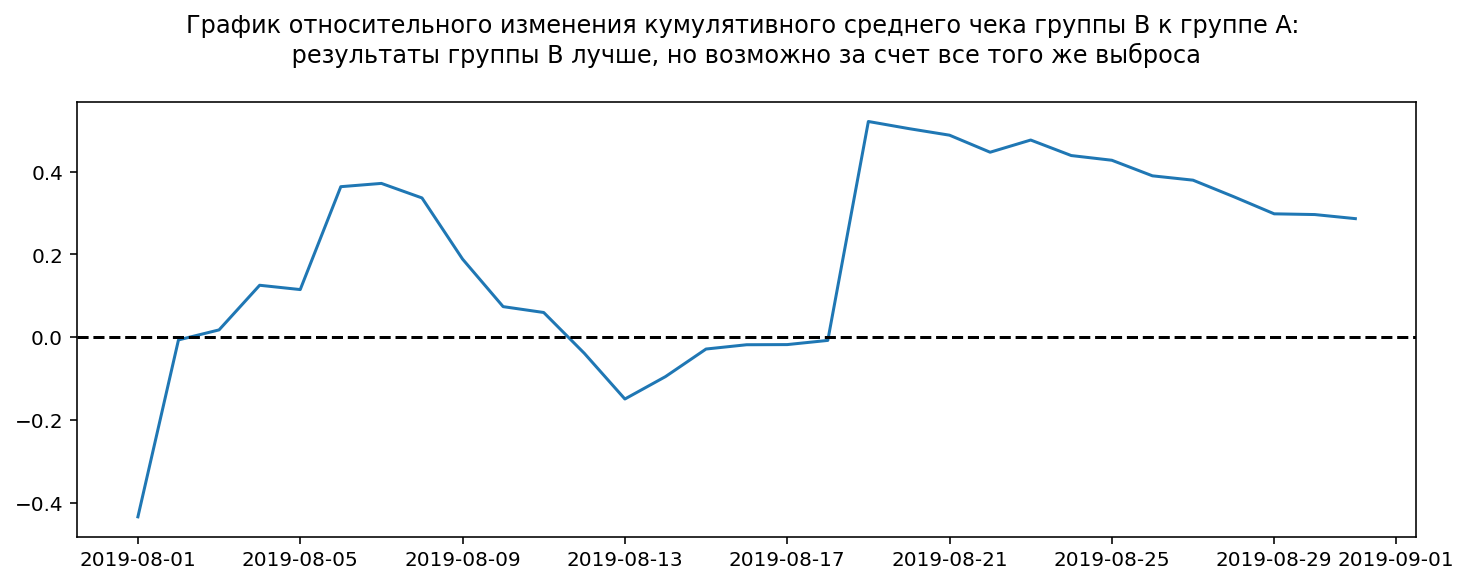

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

# cтроим отношение средних чеков

plt.figure(figsize=(12,4))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A: \n результаты группы B лучше, но возможно за счет все того же выброса \n')

plt.plot(
    mergedCumulativeRevenue['date'], 
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
    /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])
    -1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

ВЫВОД: 
- относительное изменение кумулятивного среднего чека группы B несколько лучше, но возможно за счет все того же выброса. 
- Кроме уже известного выброса есть еще несколько точек с резкими скачками.

#### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

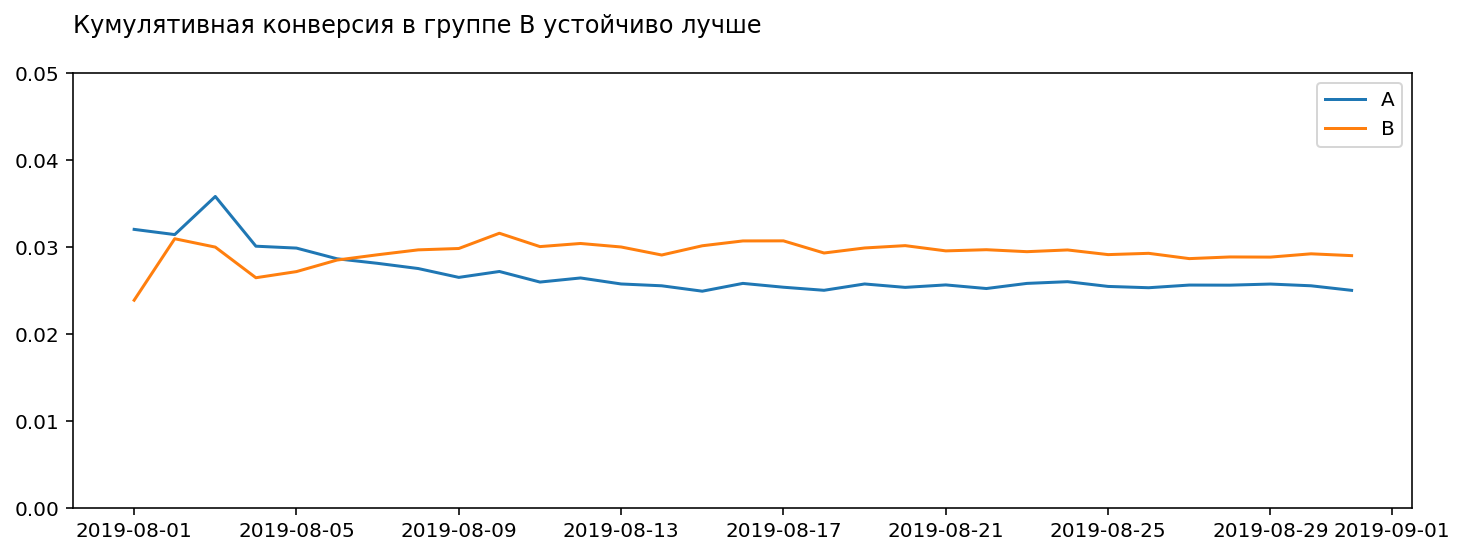

In [16]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12,4))
plt.title('Кумулятивная конверсия в группе В устойчиво лучше', loc='left', pad=20)
plt.ylim(0, 0.05)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
 
plt.legend();

In [17]:
cumulativeData.sort_values(by='date').tail(2)

,date,group,orders,buyers,revenue,visitors,conversion
60,2019-08-31,A,468,445,3364656,18736,0.024979
61,2019-08-31,B,548,528,5068972,18916,0.028970


ВЫВОД: 
- кумулятивная конверсия в группе В устойчиво лучше
- однако разница меньше процента, необходимо дополнительно проверить, является ли она статистически значимой

#### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

''

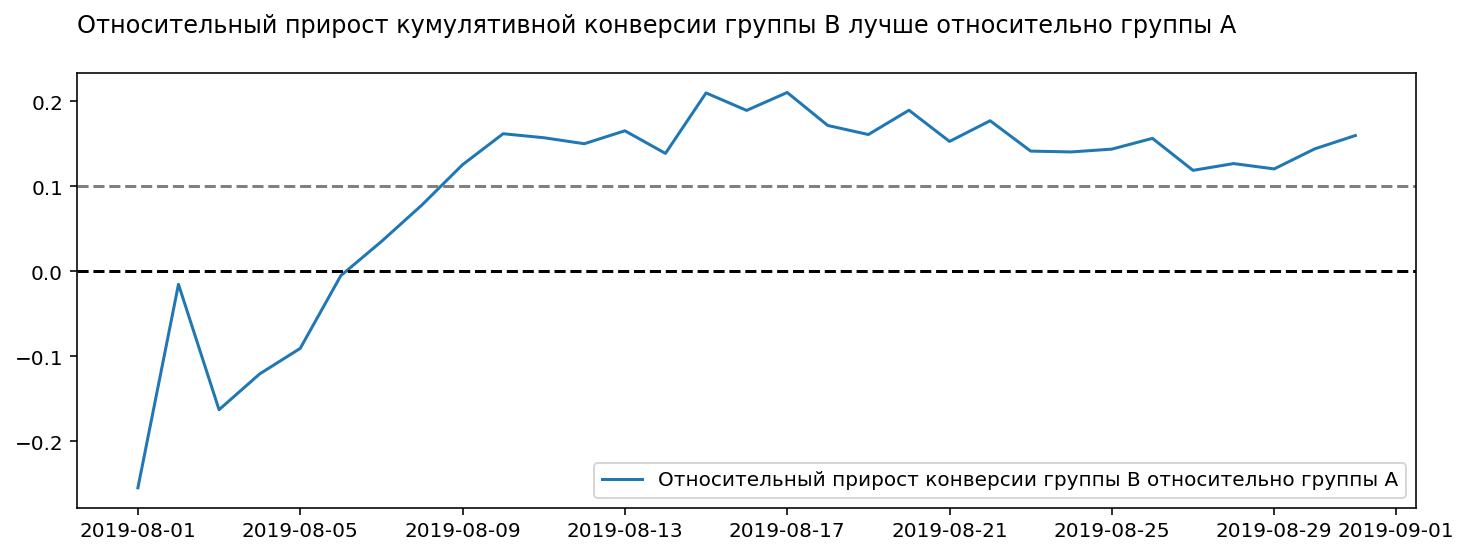

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


plt.figure(figsize=(12,4))
plt.title('Относительный прирост кумулятивной конверсии группы B лучше относительно группы A', loc='left', pad=20)

plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
    label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
;
 

ВЫВОД: 
- Относительный прирост конверсии группы B лучше относительно группы A
- разница порядка 10%

#### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [19]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


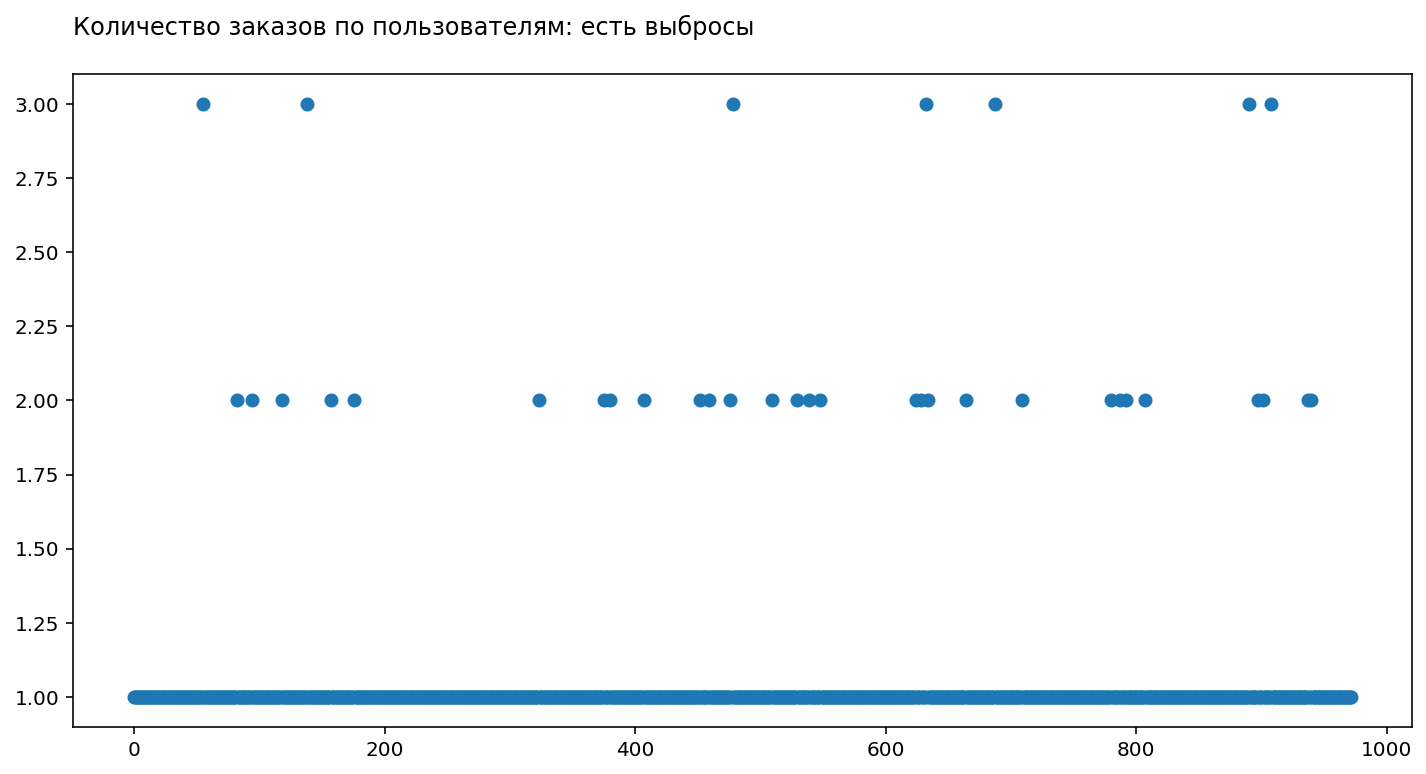

In [20]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(12,6))
plt.title('Количество заказов по пользователям: есть выбросы', loc='left', pad=20)

plt.scatter(x_values, ordersByUsers['orders']) ; 

ВЫВОД: 
- количество заказов распределено неравномерно. Небольшое количество клиентов заказывают существенно чаще остальных.

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [21]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 1. 2.]


In [32]:
orders_count = orders.groupby('userId', as_index = False)['orderId'].nunique()
print(len(orders_count))
orders_count.loc[orders_count['orderId'] > 2].count()

973


userId     7
orderId    7
dtype: int64

In [33]:
# чтобы не переписывать код дальше, изменю лимит 
# orders_count_lim = int(np.percentile(ordersByUsers['orders'], [95]))
orders_count_lim = 4

ВЫВОД: 
- ничего не чистим, т.к. аномальные пользователи удалены раньше

#### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

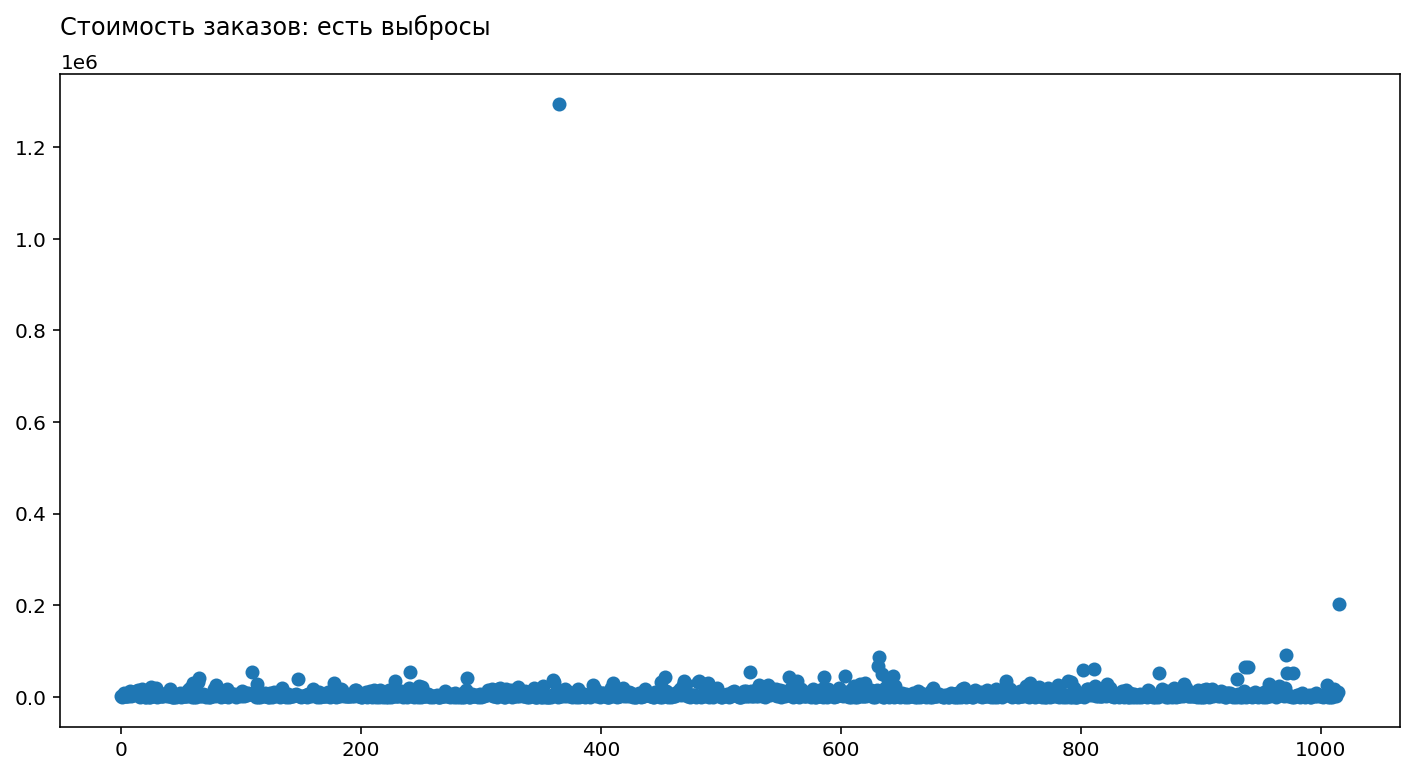

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12,6))
plt.title('Стоимость заказов: есть выбросы', loc='left', pad=20)
plt.scatter(x_values, orders['revenue']); 

ВЫВОД: 
- есть заказы, стоимость которых очень сильно превышает средний чек

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [35]:
prices = np.percentile(orders['revenue'], [90, 95, 99])
print(prices) 

[17990. 26785. 53904.]


установим 95 перцентиль порогом для стоимости заказов

In [36]:
orders_price_lim = int(np.percentile(orders['revenue'], [95]))
orders_price_lim

26785

ВЫВОД: 
- 95% заказов не дороже 26785. Отбросим все заказы с чеком больше этой суммы

#### Посчитайте по полным и очищенным от выбросов данным: 
- статистическую значимость различий в конверсии 
- статистическую значимость различий в чеке заказа

Сделайте выводы и предположения.

#### Сформулируем гипотезы:

-----
    КОНВЕРСИЯ
    
    H0: конверсия в группе А и в группе В не отличается
    
    H1: конверсия в группе А и в группе В отличается

-----
    СРЕДНИЙ ЧЕК
    
    H0: средний чек в группе А и в группе В не отличается
    
    H1: средний чек в группе А и в группе В отличается

In [37]:
# посчитаем количество посетителей на каждый день для каждой группы

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# посчитаем количество заказов на каждый день для каждой группы

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# количество заказов кумулятивно

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# соберем в одну таблицу
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [38]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [39]:
def check (sampleA, sampleB, orders):
    
    # определим, является ли конверсия статистически значимой
    alpha = 0.05
    result = stats.mannwhitneyu(sampleA, sampleB)[1]

    # также рассчитаем разницу между средним чеком в группе А и группе В
    diff = sampleB.mean() / sampleA.mean() - 1


    print('КОНВЕРСИЯ: различие между группами')

    if result < alpha:
        print ('РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА')
    else: 
        print ('НЕ МОЖЕМ УТВЕРЖДАТЬ, что разница статистически значима')

    print ('результат теста: \n', "{0:.3f}".format(result), '\n')

    print ( 
        'различие в конверсии между группами: \n', "{0:.3f}".format(diff)
          )

    print ('---------------------------------------------------------------------------------')
    print('СРЕДНИЙ ЧЕК: различие между группами')
    alpha = 0.05
    result = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
    diff = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1


    if result < alpha:
        print ('РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА')
    else: 
        print ('НЕ МОЖЕМ УТВЕРЖДАТЬ, что разница статистически значима')

    print ('результат теста: \n', "{0:.3f}".format(result), '\n')
    print ('различие в чеке между группами: \n', "{0:.3f}".format(diff))

##### Посчитаем по данным до очистки от выбросов

In [40]:
check (sampleA, sampleB, orders)

КОНВЕРСИЯ: различие между группами
РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА
результат теста: 
 0.011 

различие в конверсии между группами: 
 0.160
---------------------------------------------------------------------------------
СРЕДНИЙ ЧЕК: различие между группами
НЕ МОЖЕМ УТВЕРЖДАТЬ, что разница статистически значима
результат теста: 
 0.829 

различие в чеке между группами: 
 0.287


ВЫВОД анализа без очистки выбросов:  
- конверсия в группе В выше, статистически значимо
- конверсия выше на 16%
- различие в среднем чеке между группами равно 29%
- при этом различие не является статистически значимым

##### Очистим датафрейм с заказами от выбросов и проанализируем данные еще раз

In [41]:
# создадим таблицу abnormal users

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_count_lim]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_count_lim]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > orders_price_lim]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

print ('\nВсего пользователей с аномальным количеством / ценой заказов:')
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
684     358944393
648     382846391
Name: userId, dtype: int64

Всего пользователей с аномальным количеством / ценой заказов:
51


подготовим очищенные выборки

In [42]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

подготовим очищенный датафрейм с заказами

In [43]:
ordersFiltered = orders[np.logical_not(orders['userId'].isin(abnormalUsers))]
ordersFiltered.shape

(964, 5)

**Еще раз посчитаем статистическую достоверность и разницу в среднем чеке, на очищенных данных**

In [44]:
check (sampleAFiltered, sampleBFiltered, ordersFiltered)

КОНВЕРСИЯ: различие между группами
РАЗНИЦА СТАТИСТИЧЕСКИ ЗНАЧИМА
результат теста: 
 0.017 

различие в конверсии между группами: 
 0.156
---------------------------------------------------------------------------------
СРЕДНИЙ ЧЕК: различие между группами
НЕ МОЖЕМ УТВЕРЖДАТЬ, что разница статистически значима
результат теста: 
 0.741 

различие в чеке между группами: 
 -0.053


сигналы по конверсии близки к тем что были до очистки датасета от дублирующихся пользователей, по среднему чеку - проигрыш В усилился с 2% до 5%, но эта разница по-прежнему статистически не значима

Для проверки построю график среднего чека по очищенным данным

In [45]:
filtered_check = ( 
    (
        ordersFiltered.pivot_table(
            index='date', 
            columns='group', 
            values = ['revenue', 'orderId'], 
            aggfunc = {'revenue':'sum','orderId': pd.Series.nunique})
    )
        .cumsum()
        .assign (
                    mean_A =lambda x: x['revenue']['A']/x['orderId']['A'],
                    mean_B =lambda x: x['revenue']['B']/x['orderId']['B'], 
                )
)

filtered_check.columns=[' '.join(col).strip() for col in filtered_check.columns.values]

filtered_check.head()


,orderId A,orderId B,revenue A,revenue B,mean_A,mean_B
date,,,,,,
2019-08-01,21,17,84790,59758,4037.619048,3515.176471
2019-08-02,40,38,176392,152992,4409.800000,4026.105263
2019-08-03,64,52,288865,220041,4513.515625,4231.557692
2019-08-04,75,65,330041,285581,4400.546667,4393.553846
2019-08-05,97,85,416424,347139,4293.030928,4083.988235


''

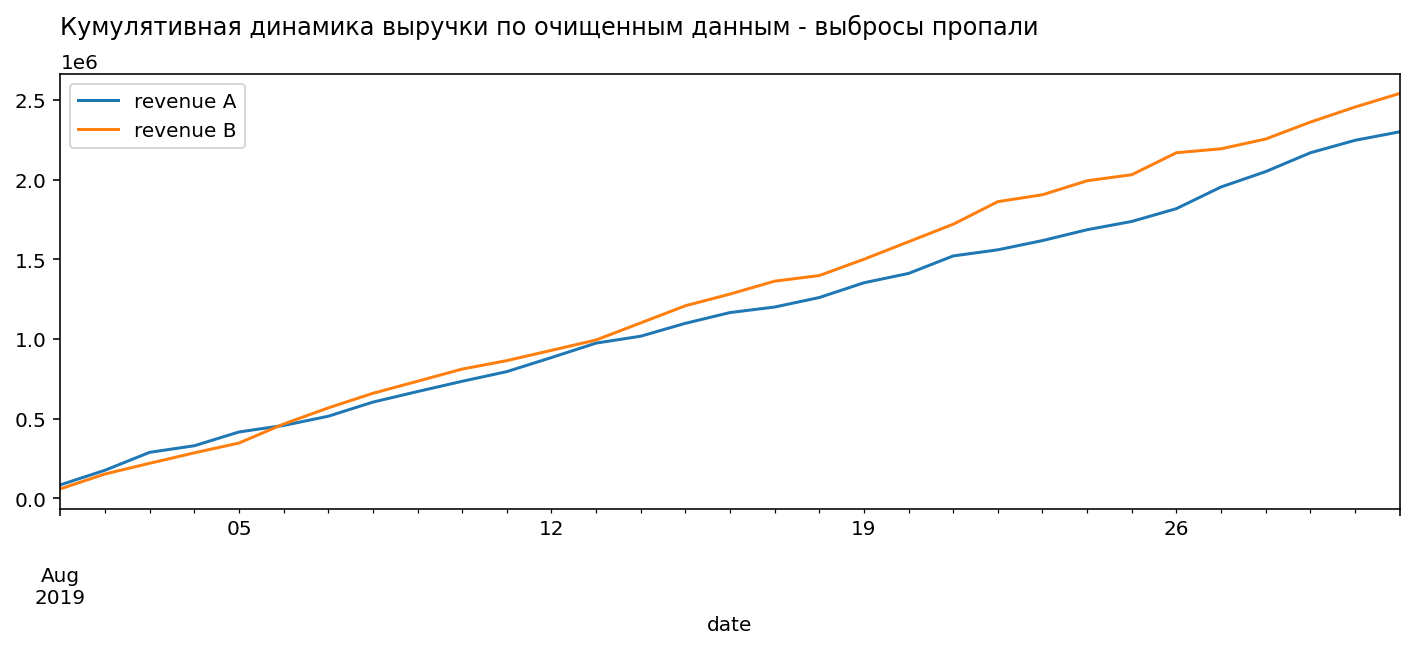

In [46]:
filtered_check[['revenue A', 'revenue B']].plot( figsize = (12,4))
plt.title(
    'Кумулятивная динамика выручки по очищенным данным - выбросы пропали', 
    loc='left', pad=20)
;


''

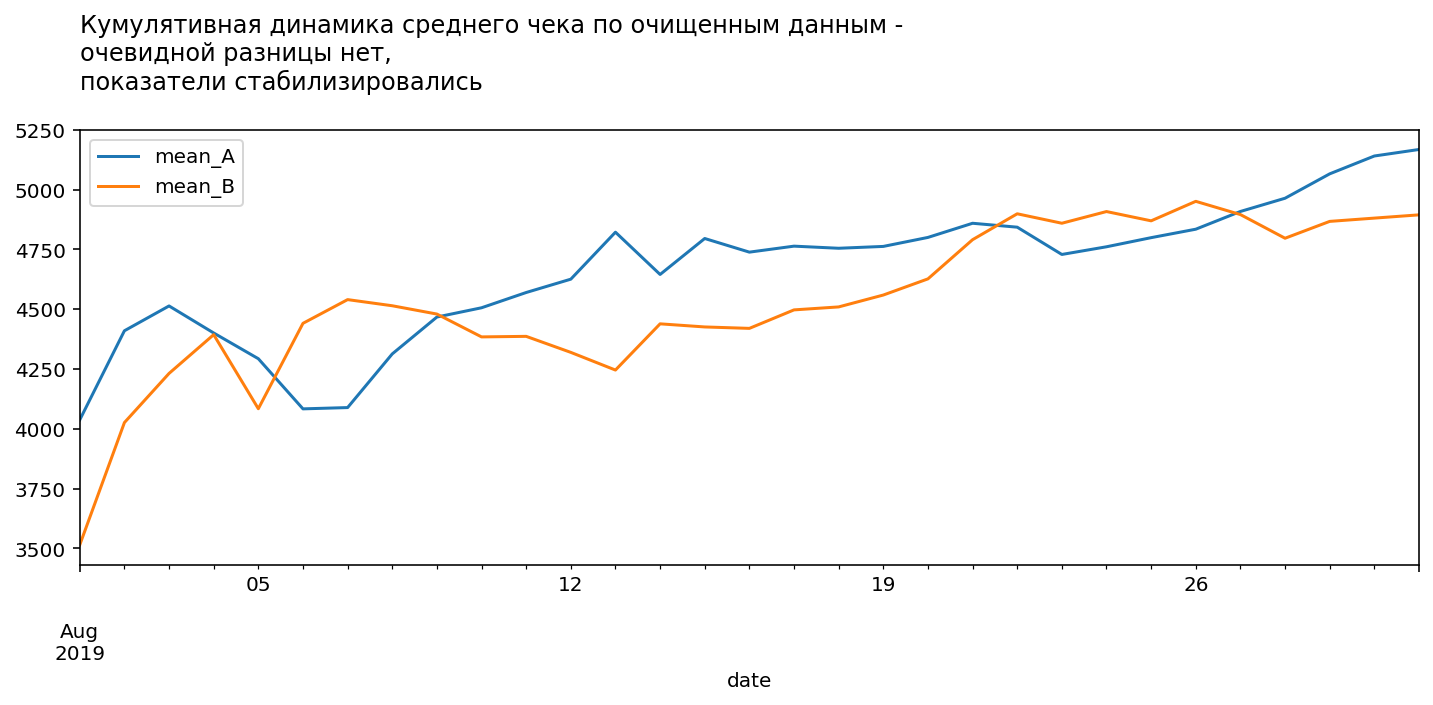

In [47]:
filtered_check[['mean_A', 'mean_B']].plot( figsize = (12,4))
plt.title(
    'Кумулятивная динамика среднего чека по очищенным данным - \nочевидной разницы нет, \nпоказатели стабилизировались', 
    loc='left', pad=20)
;


### Выводы

Суммируем предварительные выводы. 

Группа В лидирует по следующим показателям:

- кумулятивная выручка, кумулятивный средний чек (однако это вызвано одним выбросом)
- кумулятивная конверсия - здесь показатель лучше группы А на 10% (относительно) и на 0,4% в абсолюте на последнюю дату наблюдений. Показатели конверсии уже стабилизировались. 
- в данных присутствует небольшое количество существенных выбросов по цене и количеству покупок
-----
#### Выводы после очистки данных от выбросов:
- разница в конверсии между группами статистически значима. Группа В показала относительный прирост в 17%
- разница в среднем чеке статистически НЕ значима. Средний чек в группе В даже несколько ниже.

-----
#### Тест можно остановить:
- было недостаточно данных, чтобы определить необходимую продолжительность теста
- необходимый для подтверждения статистической значимости размер выборки достигнут
- метрики стабилизировались

Следовательно, 

**тест можно остановить со следующим результатом:**
 - не зафиксировано разницы по среднему чеку
 - конверсия в группе B лучше на 15% относительно конверсии в группе А
